PENDULUM SYSTEM IDENTIFICATION USING MACHINE LEARNING

1. LOADING AND PREPROCESSING DATA
Dataset loaded: 1000 samples, 3 features
Columns: ['theta', 'theta_dot', 'theta_double_dot']
No missing values found

Dataset Statistics:
           theta  theta_dot  theta_double_dot
count  1000.0000  1000.0000         1000.0000
mean      0.0156    -0.0052           -0.0207
std       0.4297     0.4192            0.4166
min      -1.1237    -1.0494           -1.1806
25%      -0.2524    -0.2873           -0.2895
50%       0.0124    -0.0177           -0.0072
75%       0.2887     0.2632            0.2552
max       1.1972     1.2479            1.1587

2. EXPLORATORY DATA ANALYSIS
Correlation Matrix:
                   theta  sin_theta  theta_dot  theta_dot_sq  theta_double_dot
theta             1.0000     0.9986    -0.0455       -0.0061           -0.9410
sin_theta         0.9986     1.0000    -0.0464       -0.0054           -0.9405
theta_dot        -0.0455    -0.0464     1.0000        0.0488            

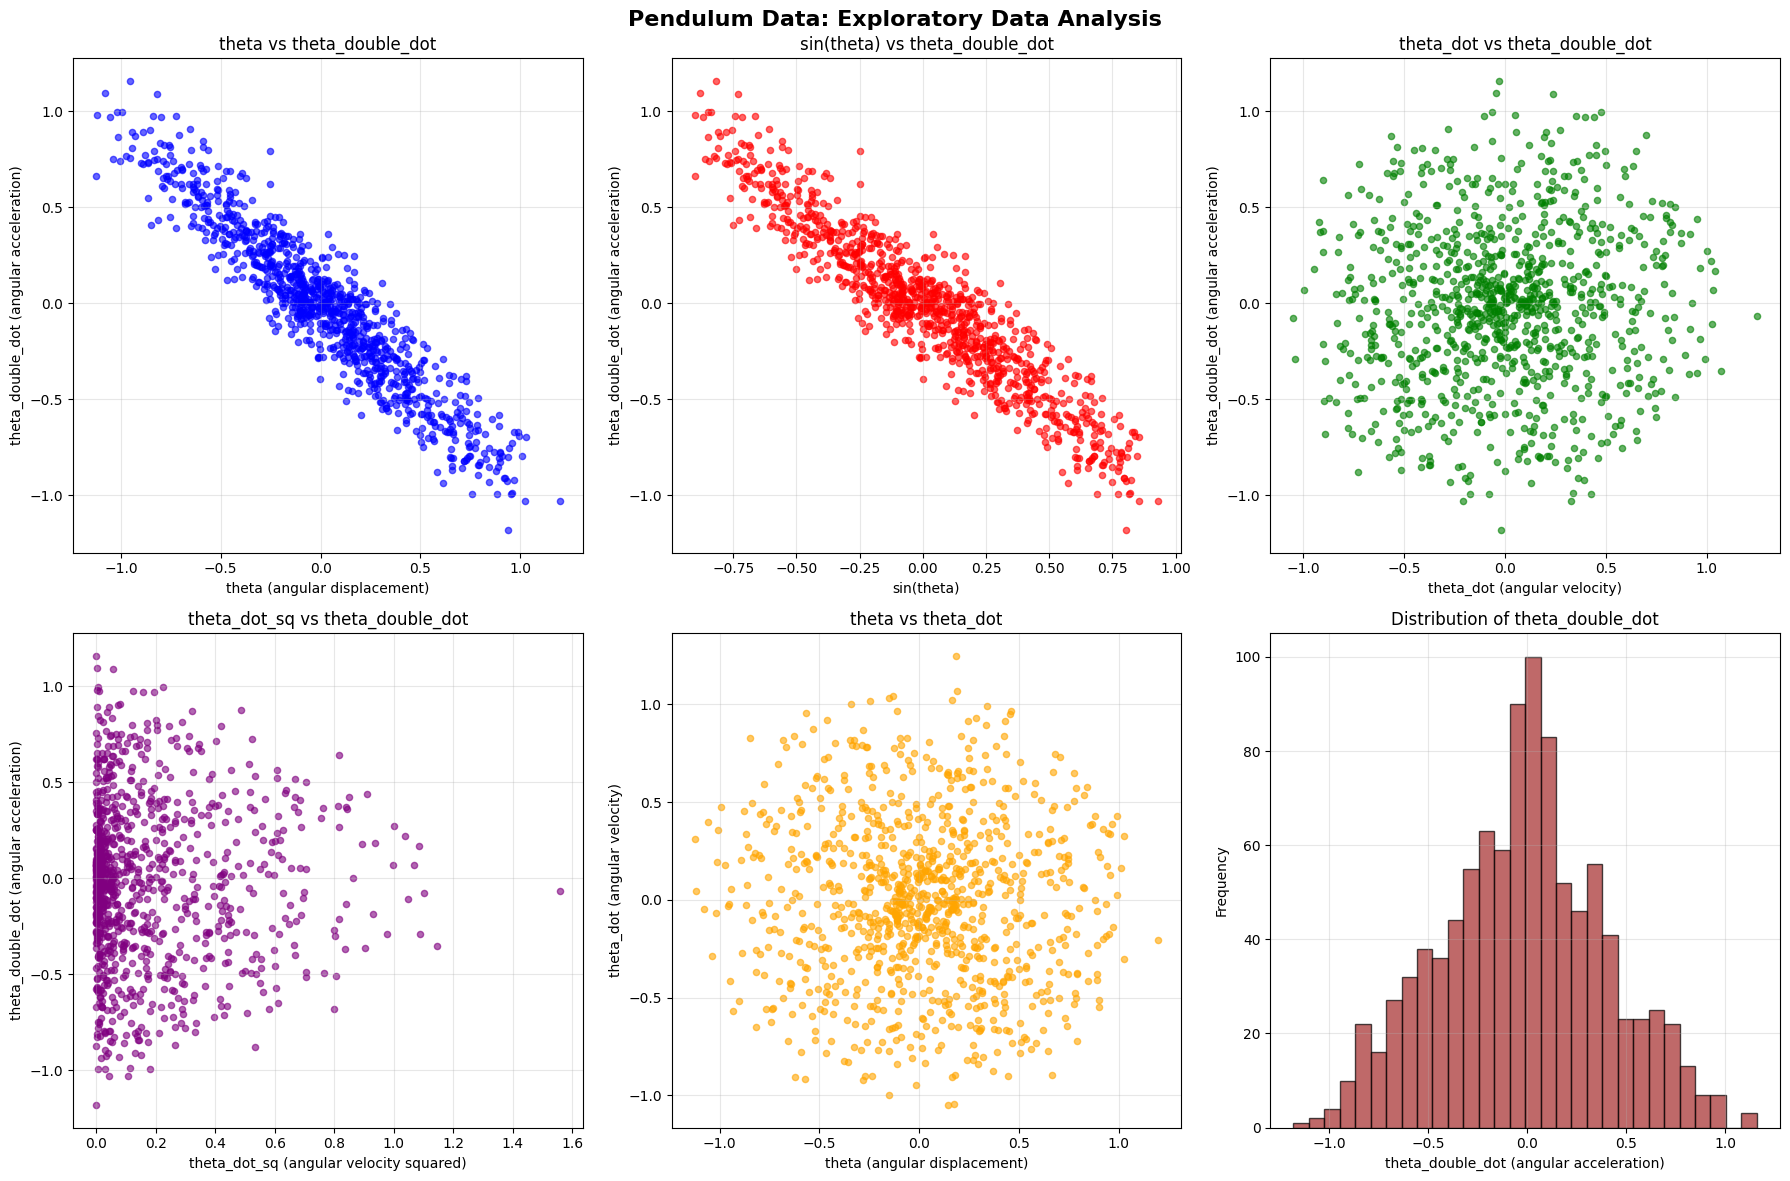


3. HYPOTHESIS SPACE DEVELOPMENT
Proposed governing equation form:
theta_double_dot = a₁·theta + a₂·sin(theta) + a₃·theta_dot + a₄·theta_dot_sq + b

Justification:
• theta term: Linear restoring force (small angle approximation)
• sin(theta) term: Nonlinear restoring force (exact pendulum dynamics)
• theta_dot term: Linear damping effects
• theta_dot_sq term: Nonlinear damping effects
• b term: Bias/offset

4. RIDGE REGRESSION MODEL FITTING
Feature matrix shape: (1000, 4)
Target vector shape: (1000,)

Optimal regularization parameter (α): 1.592283
Cross-validation score (MSE): 0.019875

Model Coefficients (original scale):
  theta: -0.529798
  sin_theta: -0.414863
  theta_dot: 0.018738
  theta_dot_sq: -0.022548
  Intercept: -0.002351

5. MODEL VALIDATION AND CROSS-VALIDATION
3-Fold CV: MSE = 0.019802 ± 0.000572, R² = 0.885059 ± 0.003966
5-Fold CV: MSE = 0.019878 ± 0.001532, R² = 0.884554 ± 0.005753
10-Fold CV: MSE = 0.019885 ± 0.002925, R² = 0.883635 ± 0.018357

Final Model Performance

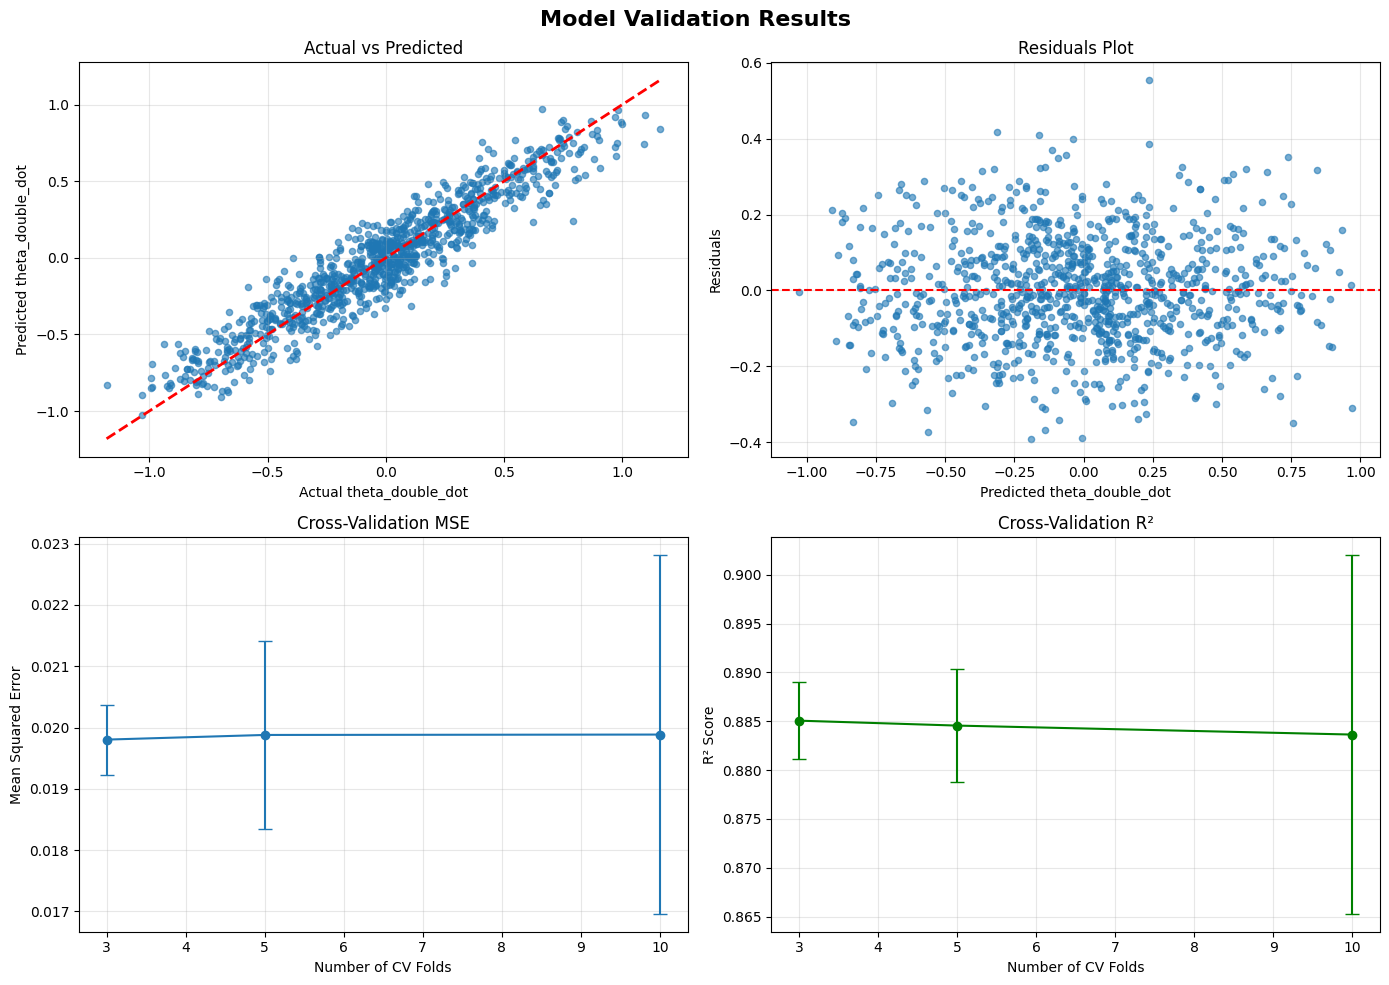

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

def main():

    print("PENDULUM SYSTEM IDENTIFICATION USING MACHINE LEARNING")

    # 1. DATA LOADING AND PREPROCESSING
    print("\n1. LOADING AND PREPROCESSING DATA")

    # Load the pendulum data
    df = pd.read_csv('hw5_0f0d0ff0-7939-409c-9824-42fb32282f32.csv')
    print(f"Dataset loaded: {df.shape[0]} samples, {df.shape[1]} features")
    print(f"Columns: {df.columns.tolist()}")

    # Check for missing values
    if df.isnull().sum().sum() == 0:
        print("No missing values found")
    else:
        print("Missing values detected:")
        print(df.isnull().sum())

    # Display basic statistics
    print("\nDataset Statistics:")
    print(df.describe().round(4))

    # Create engineered features for hypothesis space
    df['sin_theta'] = np.sin(df['theta'])
    df['theta_dot_sq'] = df['theta_dot'] ** 2

    # 2. EXPLORATORY DATA ANALYSIS
    print("\n2. EXPLORATORY DATA ANALYSIS")

    # Correlation analysis
    features = ['theta', 'sin_theta', 'theta_dot', 'theta_dot_sq', 'theta_double_dot']
    corr_matrix = df[features].corr()

    print("Correlation Matrix:")
    print(corr_matrix.round(4))

    # Key insights
    target_corr = corr_matrix['theta_double_dot'].drop('theta_double_dot')
    print("\nCorrelations with theta_double_dot (target variable):")
    for var, corr in target_corr.items():
        print(f"  {var}: {corr:.4f}")

    # Create scatter plots
    create_scatter_plots(df)

    # 3. HYPOTHESIS SPACE DEVELOPMENT
    print("\n3. HYPOTHESIS SPACE DEVELOPMENT")

    print("Proposed governing equation form:")
    print("theta_double_dot = a₁·theta + a₂·sin(theta) + a₃·theta_dot + a₄·theta_dot_sq + b")
    print("\nJustification:")
    print("• theta term: Linear restoring force (small angle approximation)")
    print("• sin(theta) term: Nonlinear restoring force (exact pendulum dynamics)")
    print("• theta_dot term: Linear damping effects")
    print("• theta_dot_sq term: Nonlinear damping effects")
    print("• b term: Bias/offset")

    # 4. MODEL FITTING WITH RIDGE REGRESSION
    print("\n4. RIDGE REGRESSION MODEL FITTING")

    # Prepare features and target
    feature_names = ['theta', 'sin_theta', 'theta_dot', 'theta_dot_sq']
    X = df[feature_names].values
    y = df['theta_double_dot'].values

    print(f"Feature matrix shape: {X.shape}")
    print(f"Target vector shape: {y.shape}")

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Ridge regression with cross-validation for alpha selection
    alphas = np.logspace(-4, 4, 100)
    ridge_cv = RidgeCV(alphas=alphas, cv=5, scoring='neg_mean_squared_error')
    ridge_cv.fit(X_scaled, y)

    print(f"\nOptimal regularization parameter (α): {ridge_cv.alpha_:.6f}")
    print(f"Cross-validation score (MSE): {-ridge_cv.best_score_:.6f}")

    # Transform coefficients back to original scale
    coefficients = ridge_cv.coef_
    intercept = ridge_cv.intercept_
    X_mean = scaler.mean_
    X_scale = scaler.scale_
    original_coefs = coefficients / X_scale
    original_intercept = intercept - np.dot(original_coefs, X_mean)

    # Display results
    print("\nModel Coefficients (original scale):")
    coef_dict = {}
    for name, coef in zip(feature_names, original_coefs):
        coef_dict[name] = coef
        print(f"  {name}: {coef:.6f}")
    print(f"  Intercept: {original_intercept:.6f}")

    # 5. MODEL VALIDATION
    print("\n5. MODEL VALIDATION AND CROSS-VALIDATION")


    # Comprehensive cross-validation
    cv_folds = [3, 5, 10]
    cv_results = perform_cross_validation(ridge_cv, X_scaled, y, cv_folds)

    # Final model performance
    y_pred = ridge_cv.predict(X_scaled)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_pred)

    print(f"\nFinal Model Performance:")
    print(f"  Mean Squared Error: {mse:.6f}")
    print(f"  Root Mean Squared Error: {rmse:.6f}")
    print(f"  R² Score: {r2:.6f}")

    # 6. DISCOVERED EQUATION
    print("\n6. DISCOVERED GOVERNING EQUATION")

    equation = f"theta_double_dot = {original_coefs[0]:.4f}·theta + {original_coefs[1]:.4f}·sin(theta) + {original_coefs[2]:.4f}·theta_dot + {original_coefs[3]:.4f}·theta_dot_sq + {original_intercept:.4f}"
    print(f"Final Equation: {equation} \n")


    # Create validation plots
    create_validation_plots(y, y_pred, cv_results)

    return {
        'equation': equation,
        'coefficients': coef_dict,
        'intercept': original_intercept,
        'performance': {'mse': mse, 'rmse': rmse, 'r2': r2},
        'model': ridge_cv,
        'scaler': scaler
    }

def create_scatter_plots(df):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Pendulum Data: Exploratory Data Analysis', fontsize=16, fontweight='bold')

    # theta vs theta_double_dot
    axes[0,0].scatter(df['theta'], df['theta_double_dot'], alpha=0.6, color='blue', s=20)
    axes[0,0].set_xlabel('theta (angular displacement)')
    axes[0,0].set_ylabel('theta_double_dot (angular acceleration)')
    axes[0,0].set_title('theta vs theta_double_dot')
    axes[0,0].grid(True, alpha=0.3)

    # sin(theta) vs theta_double_dot
    axes[0,1].scatter(df['sin_theta'], df['theta_double_dot'], alpha=0.6, color='red', s=20)
    axes[0,1].set_xlabel('sin(theta)')
    axes[0,1].set_ylabel('theta_double_dot (angular acceleration)')
    axes[0,1].set_title('sin(theta) vs theta_double_dot')
    axes[0,1].grid(True, alpha=0.3)

    # theta_dot vs theta_double_dot
    axes[0,2].scatter(df['theta_dot'], df['theta_double_dot'], alpha=0.6, color='green', s=20)
    axes[0,2].set_xlabel('theta_dot (angular velocity)')
    axes[0,2].set_ylabel('theta_double_dot (angular acceleration)')
    axes[0,2].set_title('theta_dot vs theta_double_dot')
    axes[0,2].grid(True, alpha=0.3)

    # theta_dot_sq vs theta_double_dot
    axes[1,0].scatter(df['theta_dot_sq'], df['theta_double_dot'], alpha=0.6, color='purple', s=20)
    axes[1,0].set_xlabel('theta_dot_sq (angular velocity squared)')
    axes[1,0].set_ylabel('theta_double_dot (angular acceleration)')
    axes[1,0].set_title('theta_dot_sq vs theta_double_dot')
    axes[1,0].grid(True, alpha=0.3)

    # theta vs theta_dot
    axes[1,1].scatter(df['theta'], df['theta_dot'], alpha=0.6, color='orange', s=20)
    axes[1,1].set_xlabel('theta (angular displacement)')
    axes[1,1].set_ylabel('theta_dot (angular velocity)')
    axes[1,1].set_title('theta vs theta_dot')
    axes[1,1].grid(True, alpha=0.3)

    # Distribution of theta_double_dot
    axes[1,2].hist(df['theta_double_dot'], bins=30, alpha=0.7, color='brown', edgecolor='black')
    axes[1,2].set_xlabel('theta_double_dot (angular acceleration)')
    axes[1,2].set_ylabel('Frequency')
    axes[1,2].set_title('Distribution of theta_double_dot')
    axes[1,2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('scatter_plots_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

def perform_cross_validation(model, X, y, cv_folds):
    cv_results = {}

    for folds in cv_folds:
        scores_mse = cross_val_score(model, X, y, cv=folds, scoring='neg_mean_squared_error')
        scores_r2 = cross_val_score(model, X, y, cv=folds, scoring='r2')

        cv_results[folds] = {
            'mse_mean': -scores_mse.mean(),
            'mse_std': scores_mse.std(),
            'r2_mean': scores_r2.mean(),
            'r2_std': scores_r2.std()
        }

        print(f"{folds}-Fold CV: MSE = {-scores_mse.mean():.6f} ± {scores_mse.std():.6f}, R² = {scores_r2.mean():.6f} ± {scores_r2.std():.6f}")

    return cv_results

def create_validation_plots(y_true, y_pred, cv_results):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Model Validation Results', fontsize=16, fontweight='bold')

    # Actual vs Predicted
    axes[0,0].scatter(y_true, y_pred, alpha=0.6, s=20)
    min_val, max_val = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
    axes[0,0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    axes[0,0].set_xlabel('Actual theta_double_dot')
    axes[0,0].set_ylabel('Predicted theta_double_dot')
    axes[0,0].set_title('Actual vs Predicted')
    axes[0,0].grid(True, alpha=0.3)

    # Residuals
    residuals = y_true - y_pred
    axes[0,1].scatter(y_pred, residuals, alpha=0.6, s=20)
    axes[0,1].axhline(y=0, color='r', linestyle='--')
    axes[0,1].set_xlabel('Predicted theta_double_dot')
    axes[0,1].set_ylabel('Residuals')
    axes[0,1].set_title('Residuals Plot')
    axes[0,1].grid(True, alpha=0.3)

    # Cross-validation MSE
    folds = list(cv_results.keys())
    mse_means = [cv_results[f]['mse_mean'] for f in folds]
    mse_stds = [cv_results[f]['mse_std'] for f in folds]
    axes[1,0].errorbar(folds, mse_means, yerr=mse_stds, marker='o', capsize=5)
    axes[1,0].set_xlabel('Number of CV Folds')
    axes[1,0].set_ylabel('Mean Squared Error')
    axes[1,0].set_title('Cross-Validation MSE')
    axes[1,0].grid(True, alpha=0.3)

    # Cross-validation R²
    r2_means = [cv_results[f]['r2_mean'] for f in folds]
    r2_stds = [cv_results[f]['r2_std'] for f in folds]
    axes[1,1].errorbar(folds, r2_means, yerr=r2_stds, marker='o', capsize=5, color='green')
    axes[1,1].set_xlabel('Number of CV Folds')
    axes[1,1].set_ylabel('R² Score')
    axes[1,1].set_title('Cross-Validation R²')
    axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('model_validation.png', dpi=300, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    # Run the complete analysis
    results = main()
